# **Topic-Identification**

This notebook shows examples for the nlp task ``topic identification``:<br>

* First Example: a basic sample with just a few sentences as document which should demonstrate the basic functionality in topic identification.

* Second example: a News-Article-Classification system with ``simpletransformers``

## **2- First Example**

According the tutorial [***run LDA-Model on gensim***](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html), a first basic example on Topic-Identification is shown here.

In [15]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
# Load resources

from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim import corpora, models
import gensim

In [17]:
# Create sample document

doc_set = [
           'Ben Roethlisburger, Mike Tomlin, and the rest of the Pittsburgh Steelers are in unchartered terretory.',
           'For the first time in the franchise\'s 87-year history, Pittsbourgh is undefeated through nine games after the Steelers breezed by the Bengalas Sunday at Heinz Field.'
           ]

In [18]:
# Split the documents into tokens.
## \w+ matches one or more alphanumeric characters
## Both string and bytes literals may optionally be prefixed with a letter 'r' or 'R'; 
## such strings are called raw strings and treat backslashes as literal characters.
## As a result, in string literals, '\U' and '\u' escapes in raw strings are not treated specially.
## https://docs.python.org/3/reference/lexical_analysis.html
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(doc_set)):
    doc_set[idx] = doc_set[idx].lower()  # Convert to lowercase.
    doc_set[idx] = tokenizer.tokenize(doc_set[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
doc_set = [[token for token in doc if not token.isnumeric()] for doc in doc_set]

# Remove words that are only one character.
doc_set = [[token for token in doc if len(token) > 1] for doc in doc_set]

"We use the WordNet lemmatizer from NLTK. A lemmatizer is preferred over a stemmer in this case because it produces more readable words. Output that is easy to read is very desirable in topic modelling."

In [22]:
# Lemmatize the documents.
lemmatizer = WordNetLemmatizer()
doc_set = [[lemmatizer.lemmatize(token) for token in doc] for doc in doc_set]

print(doc_set)

[['ben', 'roethlisburger', 'mike', 'tomlin', 'and', 'the', 'rest', 'of', 'the', 'pittsburgh', 'steelers', 'are', 'in', 'unchartered', 'terretory'], ['for', 'the', 'first', 'time', 'in', 'the', 'franchise', 'year', 'history', 'pittsbourgh', 'is', 'undefeated', 'through', 'nine', 'game', 'after', 'the', 'steelers', 'breezed', 'by', 'the', 'bengalas', 'sunday', 'at', 'heinz', 'field']]


"We find bigrams in the documents. Bigrams are sets of two adjacent words. Using bigrams we can get phrases like “machine_learning” in our output (spaces are replaced with underscores); without bigrams we would only get “machine” and “learning”.

Note that in the code below, we find bigrams and then add them to the original data, because we would like to keep the words “machine” and “learning” as well as the bigram “machine_learning”."

In [24]:
# Compute bigrams.
from gensim.models.phrases import Phrases

# Add bigrams and trigrams to doc_set (only ones that appear 20 times or more).
bigram = Phrases(doc_set, min_count=20)
for idx in range(len(doc_set)):
    for token in bigram[doc_set[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            doc_set[idx].append(token)


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [25]:
# Remove rare and common tokens.???

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(doc_set)

"Finally, we transform the documents to a vectorized form. We simply compute the frequency of each word, including the bigrams."

In [30]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in doc_set]

In [31]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 34
Number of documents: 2


"First of all, the elephant in the room: how many topics do I need? There is really no easy answer for this, it will depend on both your data and your application. I have used 10 topics here because I wanted to have a few topics that I could interpret and “label”, and because that turned out to give me reasonably good results. You might not need to interpret all your topics, so you could use a large number of topics, for example 100.

chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory. I’ve set chunksize = 2000, which is more than the amount of documents, so I process all the data in one go. Chunksize can however influence the quality of the model, as discussed in Hoffman and co-authors [2], but the difference was not substantial in this case.

passes controls how often we train the model on the entire corpus. Another word for passes might be “epochs”. iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of “passes” and “iterations” high enough."



In [32]:
# Set training parameters.
num_topics = 2
chunksize = 2000
passes = 10
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [33]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -9.5434.
[([(0.08842242, 'the'),
   (0.042436007, 'steelers'),
   (0.04165093, 'in'),
   (0.027841331, 'terretory'),
   (0.027734792, 'pittsburgh'),
   (0.027661433, 'are'),
   (0.027639356, 'unchartered'),
   (0.0275675, 'roethlisburger'),
   (0.027539387, 'of'),
   (0.027414512, 'and'),
   (0.02728834, 'rest'),
   (0.027286924, 'tomlin'),
   (0.027172513, 'mike'),
   (0.027074065, 'ben'),
   (0.026536081, 'nine'),
   (0.026511887, 'by'),
   (0.026432268, 'time'),
   (0.026427321, 'is'),
   (0.026405847, 'history'),
   (0.026342431, 'pittsbourgh')],
  -9.543422031277052),
 ([(0.11295335, 'the'),
   (0.045094796, 'steelers'),
   (0.044663116, 'in'),
   (0.026343878, 'terretory'),
   (0.02628731, 'pittsburgh'),
   (0.026248146, 'are'),
   (0.026236327, 'unchartered'),
   (0.026197772, 'roethlisburger'),
   (0.026182653, 'of'),
   (0.026115265, 'and'),
   (0.026046842, 'rest'),
   (0.02604607, 'tomlin'),
   (0.025983775, 'mike'),
   (0.025929993, 'ben'),
   (0.02

In [34]:
print(model.print_topics(num_topics=2, num_words=4))

[(0, '0.088*"the" + 0.042*"steelers" + 0.042*"in" + 0.028*"terretory"'), (1, '0.113*"the" + 0.045*"steelers" + 0.045*"in" + 0.026*"terretory"')]


In [35]:
print(model.print_topics(num_topics=2, num_words=2))

[(0, '0.088*"the" + 0.042*"steelers"'), (1, '0.113*"the" + 0.045*"steelers"')]


## **3-Second Example (News-Article-Classification)**

### **Preparations**

**Note:**<br>
Make sure that you use an GPU for that operation.
To train the model will take several time and with a GPU you can fasten that task. 

In [ ]:
# Note: after installing simpletransformers, one must restart the runtime

!pip install simpletransformers

To download a dataset from [kaggle.com](www.kaggle.com), one must sign up for an account first.<br><br>
Here, there are 2 ways shown, how to load the data set into colab:
- upload file from a local storage
- load dataset directly from kaggle.com

To download directly from kaggle there is an [official kaggle-api](https://github.com/Kaggle/kaggle-api) which makes the usage very easy.

Structure the colab environment for the data set from [kaggle.com](www.kaggle.com) as follows:

content/
>> kaggle/
>>> News_Category_Dataset_v2.json 


In [ ]:
# Create 'kaggle' folder
!mkdir '/content/kaggle'

#### **Upload data set from a local storage**

In [ ]:
from google.colab import files

files.upload()

Saving archive (1).zip to archive (1).zip


#### **Download data set from kaggle.com via api**


* Create api-token:<br>
To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. 
Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and 
select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 
Place this file in the location 'root/.kaggle/kaggle.json'.

* Secure your api-token:<br>
For your security, ensure that other users of your computer do not have read access to your credentials.
On Unix-based systems you can do this with the following command:
chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Prepare folders in colab environment
# import os

# os.mkdir('/root/.kaggle')
# os.chdir('/root/.kaggle')

In [ ]:
# After downloading the api-token, bring it into colab:

# from google.colab import files

# files.upload()

In [ ]:
# Change access of the api-token
# os.chmod('/root/.kaggle/kaggle.json', 600)

# Get back to the kaggle folder
# os.chdir('/content/kaggle')

In [ ]:
# Download dataset
# !kaggle datasets download -d rmisra/news-category-dataset

In [ ]:
 # Unpack dataset
 
 !unzip news-category-dataset.zip

Archive:  news-category-dataset.zip
  inflating: News_Category_Dataset_v2.json  


In [ ]:
# Get back to default ('content/') location
!cd ..

### **Load data set**

We import all necessary libraries. Among the simpletransformers library,
we also need functions from scikit-learn (Pedregosa et al., 2011) and the Pandas
library (Reback et al., 2020) to load and extract our training text corpus from the
JSON file.
In google-colab, pandas and scikit-learn are pre-installed.
We extract our training text corpus and import it into a Pandas data frame df (line
7).

In [ ]:
import pandas as pd
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Read data from JSON
df = pd.read_json("/content/kaggle/News_Category_Dataset_v2.json", orient="records", lines=True)

Look at some of the dataset entries:

In [ ]:
df.head(3)

category  ...       date
0          CRIME  ... 2018-05-26
1  ENTERTAINMENT  ... 2018-05-26
2  ENTERTAINMENT  ... 2018-05-26

[3 rows x 6 columns]

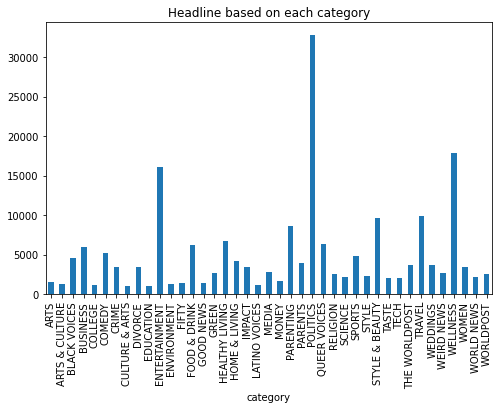

In [ ]:
# Display category distribution
from matplotlib import pyplot as plt

ax = df.groupby("category").count()["headline"].plot(kind="bar", 
                                                 figsize=(8, 5),
                                                 title="Headline based on each category")
plt.show()

### **Data Preparation**

Because our classification model expects its input in a certain structure, we prepare
a new data frame data. This data frame has a column text that contains the
concatenated headlines and corresponding short descriptions. We create a
column labels that contains the category of the article.

In [ ]:
data = pd.DataFrame()
data["text"] = df.headline + " " + df.short_description
data["labels"] = df.category

# show the new structure
data.head(3)

text         labels
0  There Were 2 Mass Shootings In Texas Last Week...          CRIME
1  Will Smith Joins Diplo And Nicky Jam For The 2...  ENTERTAINMENT
2  Hugh Grant Marries For The First Time At Age 5...  ENTERTAINMENT

The classification model needs to get only unique labels. ``lables`` lists only the unique labels from ``data``.

In [ ]:
labels = list(data["labels"].unique())

Since our model accepts only numeric values for the target features (our article categories),
we need to use scikit-learn’s LabelEncoder to encode our string-based
labels (“CRIME,” “SPORTS,” “ENTERTAINMENT”) as integers

In [ ]:
# Convert labels to numerical values
le = preprocessing.LabelEncoder()
le.fit(labels)
data["labels"] = le.transform(data["labels"])

We split our data set into training (80%) and evaluation set (20%) using scikit-learn’s
train_test_split function. Please note that we refrain from creating a
third set for the final evaluation to simplify this demonstration.

In [ ]:
train_df, eval_df = train_test_split(data, test_size=0.2)

### **Create classification model**

We create our classification model. We use a model
bert_base_uncased (uncased monolingual English version of BERT published by
Google) from the “bert” model family. The number of labels (categories) is set
through the num_labels parameter.

In [ ]:
# Create a classification model
model = ClassificationModel('bert', 'bert-base-uncased', 
                            num_labels=len(labels))

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

### **Train model**

We can start training our model. This automatically downloads the pre-trained
BERT model, initializes its parameters, and preprocesses our training data using a
subword tokenizer before the actual training process is started.

In [ ]:
# Train the model
model.train_model(train_df)

  0%|          | 0/160682 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/20086 [00:00<?, ?it/s]

(20086, 1.9863199661854467)

### **Evaluation**

We evaluate the model on our evaluation set.

In [ ]:
# Evaluate the model
result, model_outputs, predictions = model.eval_model(eval_df)

  0%|          | 0/40171 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5022 [00:00<?, ?it/s]

In [ ]:
print(result)

{'mcc': 0.4879749448652145, 'eval_loss': 1.7172067471824761}


In [ ]:
print(model_outputs)

[[-2.10742188 -0.04196167 -0.26733398 ... -0.09558105  3.2421875
   0.62695312]
 [-1.72851562 -2.21679688  0.47729492 ...  0.9453125  -2.50195312
  -2.01367188]
 [ 1.59375    -1.87695312  0.73876953 ...  0.63085938 -1.34082031
   2.4296875 ]
 ...
 [-1.86621094 -0.34545898 -0.46850586 ... -0.33129883  2.39648438
   0.31323242]
 [-1.19238281  0.35546875 -1.03125    ... -0.7890625  -0.35180664
  -1.87011719]
 [ 1.51269531 -2.14453125  0.60498047 ...  0.38745117 -1.30175781
   2.60546875]]


In [ ]:
Copyright © 2021 IU International University of Applied Sciences